In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from nltk.tokenize import word_tokenize, RegexpTokenizer

In [2]:
df = pd.read_csv("news_headlines_train.csv", delimiter=",")

In [3]:
df.head()

,text,sentiment
0,"In addition , a further 29 employees can be la...",-1
1,The authorisation is in force until the end of...,0
2,The value of the deal was not disclosed .,0
3,You need to be ready when the window opens up ...,0
4,Major Order in India Comptel Corporation has r...,1


In [4]:
len(df)

3193

## Data Exploration

In [34]:
df.sentiment.value_counts()

 0    1898
 1     908
-1     387
Name: sentiment, dtype: int64

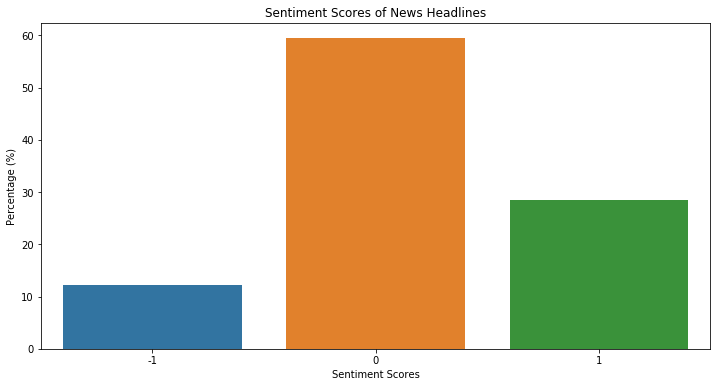

In [35]:
counts = df.sentiment.value_counts(normalize = True) *100

fig, ax = plt.subplots(figsize = (12,6))
# plt.figure(figsize=(12,6))

sns.barplot(x=counts.index,y=counts, ax=ax)

ax.set_title("Sentiment Scores of News Headlines")
ax.set_xlabel("Sentiment Scores")
ax.set_ylabel("Percentage (%)");

# plt.title("Sentiment Scores of News Headlines")
# plt.xlabel("Sentiment Scores")
# plt.ylabel("Percentage (%)")
# plt.show();


In [36]:
temp = []
for headlines in df.text:
    # Lowercase the headlines
    headlines = headlines.lower()
    # Removing punctuations
    headlines = re.sub("[,.®'&$’\"\-()]", " ", headlines)
    temp.append(word_tokenize(headlines))
df["Tokens"] = temp

# Getting the length of the headlines
df["Length"] = df["Tokens"].apply(lambda x: len(x))

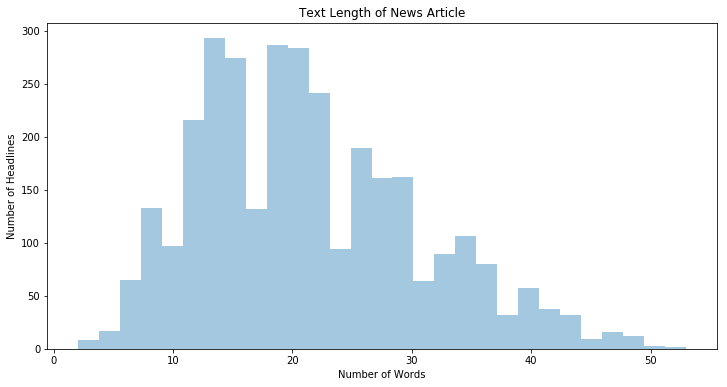

In [37]:
plt.figure(figsize=(12,6))

sns.distplot(df["Length"], kde = False)


plt.title("Text Length of News Article")
plt.xlabel("Number of Words")
plt.ylabel("Number of Headlines");

## Naive Bayes Algorithm

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.3, random_state=42)

In [40]:
token = RegexpTokenizer(r"[a-zA-Z0-9]+")
cv = CountVectorizer(stop_words="english", tokenizer=token.tokenize)

In [41]:
text_counts = cv.fit_transform(X_train)

In [42]:
mnb_model1 = MultinomialNB()
mnb_model1.fit(text_counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
test_counts = cv.transform(X_test)

In [44]:
pred1 = mnb_model1.predict(test_counts)

In [45]:
acc_score1 = accuracy_score(pred1, y_test)

In [46]:
print(acc_score1)

0.7118997912317327


Naive Bayes accuracy seems to be performing okay, but not that great

### Naive Bayes Submissions

In [65]:
subm_df = pd.read_csv("news_headlines_test_sample_submission.csv")

In [66]:
subm_df.head()

,text,sentiment
0,Proline Plus is available in both adjustable s...,0
1,Digia said its consolidated net sales for Janu...,0
2,Cash flow from operating activities is estimat...,0
3,11 August 2010 - Finnish measuring equipment m...,0
4,Metso Foundries Jyvaskyla Oy will discontinue ...,0


In [67]:
mnb_model3 = MultinomialNB()

# Training model with the entire dataset
text_counts3 = cv.fit_transform(df["text"])
mnb_model3.fit(text_counts3, df["sentiment"])

# Transforming submission dataset
subm_X1 = cv.transform(subm_df["text"])

# Making predictions for submission dataset
pred3 = mnb_model3.predict(subm_X1)

In [68]:
# Exporting
subm_df['sentiment'] = np.array(pred3)
subm_df.to_csv('Subm_naivebayes1.csv', index=False)

## VADER Method

In [69]:
#import nltk
#nltk.download('vader_lexicon')

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/Daniel/anaconda3/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [71]:
sid = SentimentIntensityAnalyzer()

In [73]:
df["vader_score"] = df["text"].apply(lambda x: sid.polarity_scores(x))

In [74]:
df["compound"] = df["vader_score"].apply(lambda x: x["compound"])

In [75]:
def score_label(score):
    if score > 0:
        return 1
    elif score == 0:
        return 0
    else:
        return -1

In [76]:
# Getting the predicted labels from compound score
df["vader_pred"] = df["compound"].apply(score_label)

In [77]:
vader_acc = accuracy_score(df["sentiment"], df["vader_pred"])

In [78]:
print(vader_acc)

0.5537112433448168


Seems like VADER sentiment analysis is not performing well

### VADER Submission

In [7]:
# Creating a function to run VADER
def vader_sentiment(column):
    vader_score = column.apply(lambda x: sid.polarity_scores(x))
    compound= vader_score.apply(lambda x: x["compound"])
    vader_pred = compound.apply(score_label)
    return vader_pred

In [80]:
subm_df = pd.read_csv("news_headlines_test_sample_submission.csv")
subm_df['sentiment'] = vader_sentiment(subm_df["text"])

# Exporting
subm_df.to_csv('Subm_vader1.csv', index=False)

## Sentiment Analysis with BERT
Since there are 3 labels for the sentiment, we will be using a Multiclass Text Classification BERT Model

In [6]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertForSequenceClassification

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [8]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Preparing the data for the BERT Model training

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)

In [11]:
tokenized_text = [tokenizer.tokenize(text) for text in df["text"]]

ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]

labels = df["sentiment"].values

print(tokenized_text[0])

print(ids[0])
print(labels[0])

['in', 'addition', ',', 'a', 'further', '29', 'employees', 'can', 'be', 'laid', 'off', 'until', 'further', 'notice', 'and', 'the', 'whole', 'workforce', 'can', 'be', 'laid', 'off', 'for', 'short', 'periods', 'if', 'needed', '.']
[1107, 1901, 117, 170, 1748, 1853, 4570, 1169, 1129, 3390, 1228, 1235, 1748, 4430, 1105, 1103, 2006, 17034, 1169, 1129, 3390, 1228, 1111, 1603, 6461, 1191, 1834, 119]
-1


In [12]:
max_len = len(ids[0])
for i in ids:
    if(len(i)>max_len):
        max_len = len(i)
print(max_len)

130


In [13]:
input_ids = pad_sequences(ids, maxlen= max_len, dtype = "long",\
                         truncating = "post", padding = "post")
print(input_ids)

[[ 1107  1901   117 ...     0     0     0]
 [ 1103  2351  5771 ...     0     0     0]
 [ 1103  2860  1104 ...     0     0     0]
 ...
 [  189 12577  2497 ...     0     0     0]
 [  185  5822  2211 ...     0     0     0]
 [ 1104  1736   117 ...     0     0     0]]


In [10]:
# Creating a label converter (using -1 encounter an error when training)
# Negative --> 0
# Neutral --> 1
# Positive --> 2

def label_converter(label):
    if label == -1:
        return 0
    elif label == 0:
        return 1
    else:
        return 2

In [15]:
df["labels"] = df["sentiment"].apply(label_converter)

In [16]:
labels = df["labels"].values

In [17]:
# Splitting the data into training (90%) and validation sets (10%)
X_train, X_test, y_train, y_test = train_test_split(df["text"], labels, test_size=0.1, random_state=42)

In [18]:
# Tokenising the text for training and validation sets
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length = 64,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_test.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=64, 
    return_tensors='pt'
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/Daniel/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
# Creating a TensorDataset object for train_data and test_data
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test)

train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_data = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [20]:
# Creating the DataLoader for model training
batch_size= 30

train_loader = DataLoader(train_data, batch_size = batch_size, \
                         sampler = RandomSampler(train_data))
test_loader = DataLoader(test_data, batch_size = batch_size,\
                        sampler = SequentialSampler(test_data))

In [21]:
# Loading the pre-trained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-cased",\
                                                      num_labels =3,\
                                                     output_attentions = False,\
                                                     output_hidden_states = False)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [22]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### The training took some time, so I saved the trained models at each epoch into a file and loaded the lastest model to continue training...

### Loading the latest model to continue training

In [23]:
# Loading the latest model to continue training
model.load_state_dict(torch.load("data_volume/finetuned_Bert_epoch_5.model",\
                              map_location = torch.device('cpu')))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
# Using an Adam optimiser for model training
optimizer = AdamW(model.parameters(), lr=1e-5, eps = 1e-8)

epochs = 4

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,\
                                           num_training_steps = len(train_loader)*epochs)

### Creating functions for the metrics to show during training

In [9]:
# Metrics to show when training
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return f1_score(labels, preds, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds = np.argmax(preds, axis=1).flatten()
    labels= labels.flatten()

    for label in np.unique(labels):
        y_preds = preds[labels==label]
        y_true = labels[labels==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

### Creating a model evaluation function

In [26]:
# Creating a model evaluation function

import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.cuda.manual_seed_all(seed_val)


def evaluate(val_loader):
    model.eval()
    
    loss_val = 0
    predictions, true_vals = [], []
    
    for batch in val_loader:
        batch = tuple(x.to(device) for x in batch)
        
        inputs = {"input_ids": batch[0],
                  "attention_mask": batch[1],
                 "labels": batch[2]}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_avg = loss_val / len(val_loader)
    
    predictions = np.concatenate(predictions, axis =0)
    true_vals = np.concatenate(true_vals, axis = 0)
    
    return loss_avg, predictions, true_vals


### Model Training

In [27]:
for epoch in tqdm(range(6, 10)):
    model.train()
    train_loss = 0
    
    progress = tqdm(train_loader, desc = "Epoch {:1d}".format(epoch),\
                   disable = False, leave=False)
    for batch in progress:
        model.zero_grad()
        batch = tuple(x.to(device) for x in batch)

        inputs = {"input_ids": batch[0],
                  "attention_mask": batch[1],
                 "labels": batch[2]}
        outputs = model(**inputs)
        
        loss = outputs[0]
        train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress.set_postfix({'training_loss:': "{:.3f}".format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f"data_volume/finetuned_Bert_epoch_{epoch}.model")
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = train_loss/len(train_loader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    loss_val_avg, predictions, true_vals = evaluate(test_loader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {loss_val_avg}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 6
Training loss: 0.12146943404028814
Validation loss: 0.6087845509702509
F1 Score (Weighted): 0.8481668994413407



Epoch 7
Training loss: 0.07777264921120756
Validation loss: 0.7050655077804219
F1 Score (Weighted): 0.8450843614281871



Epoch 8
Training loss: 0.049247221223292094
Validation loss: 0.7406000440770929
F1 Score (Weighted): 0.8481822362370254



Epoch 9
Training loss: 0.0414903929195134
Validation loss: 0.7783354629169811
F1 Score (Weighted): 0.8412518697985188



### BERT Model Evaluation

In [28]:
loss_val, predictions, true_vals = evaluate(test_loader)

In [29]:
test_pred_argmax = [x.argmax() for x in predictions]

In [30]:
accuracy_score(y_test, test_pred_argmax)

0.840625

BERT Model does quite well. Performs the best compared to Naive Bayes and VADER

## BERT Submission

In [31]:
subm_df = pd.read_csv("news_headlines_test_sample_submission.csv")

In [11]:
# Creating a predict function that takes in the submission DataLoader
def predict(model, subm_loader):
    model.eval()
    
    predictions = []
    
    for batch in subm_loader:
        batch = tuple(x.to(device) for x in batch)
        
        inputs = {"input_ids": batch[0],
                  "attention_mask": batch[1]}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
       
        logits = outputs[0]
        
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    
    predictions = np.concatenate(predictions, axis =0)
    
    return predictions

In [33]:
# Preparing the submission text data for our BERT Model
encoded_data_subm = tokenizer.batch_encode_plus(
    subm_df["text"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=64, 
    return_tensors='pt'
)

input_ids_subm = encoded_data_subm['input_ids']
attention_masks_subm = encoded_data_subm['attention_mask']
subm_data = TensorDataset(input_ids_subm, attention_masks_subm)

subm_loader = DataLoader(subm_data, batch_size = batch_size,\
                        sampler = SequentialSampler(subm_data))


/Users/Daniel/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [34]:
len(subm_df["text"])

807

In [35]:
# Making the prediction with our fine-tuned BERT Model
pred = predict(model, subm_loader)

In [36]:
# Making sure that we get predictions for all the text in the submission file
len(pred)

807

In [37]:
final = [x.argmax() for x in pred]

In [12]:
# Converting the labels back to the original labels
# Negative --> -1
# Neutral --> 0
# Positive --> 1

def id_converter(label):
    if label == 0:
        return -1
    elif label == 1:
        return 0
    else:
        return 1

In [39]:
# Getting the labels for the submission texts
final_labels = [id_converter(x) for x in final]

In [40]:
subm_df['sentiment'] = final_labels

# Exporting
subm_df.to_csv('Subm_BERT2.csv', index=False)

## Sentiment Analysis with RoBERTa

In [13]:
from transformers import RobertaTokenizer,RobertaForSequenceClassification
from transformers import RobertaConfig

In [14]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

In [11]:
tokenized_text = [tokenizer.tokenize(text) for text in df["text"]]

ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]

labels = df["sentiment"].values

print(tokenized_text[0])

print(ids[0])
print(labels[0])

['In', 'Ġaddition', 'Ġ,', 'Ġa', 'Ġfurther', 'Ġ29', 'Ġemployees', 'Ġcan', 'Ġbe', 'Ġlaid', 'Ġoff', 'Ġuntil', 'Ġfurther', 'Ġnotice', 'Ġand', 'Ġthe', 'Ġwhole', 'Ġworkforce', 'Ġcan', 'Ġbe', 'Ġlaid', 'Ġoff', 'Ġfor', 'Ġshort', 'Ġperiods', 'Ġif', 'Ġneeded', 'Ġ.']
[1121, 1285, 2156, 10, 617, 1132, 1321, 64, 28, 4976, 160, 454, 617, 3120, 8, 5, 1086, 6862, 64, 28, 4976, 160, 13, 765, 5788, 114, 956, 479]
-1


In [12]:
max_len = len(ids[0])
for i in ids:
    if(len(i)>max_len):
        max_len = len(i)
print(max_len)

85


In [13]:
input_ids = pad_sequences(ids, maxlen= max_len, dtype = "long",\
                         truncating = "post", padding = "post")
print(input_ids)

[[ 1121  1285  2156 ...     0     0     0]
 [  133  2730  3258 ...     0     0     0]
 [  133   923     9 ...     0     0     0]
 ...
 [  565  4503  3952 ...     0     0     0]
 [  642  3894   795 ...     0     0     0]
 [10643   768  2156 ...     0     0     0]]


In [15]:
# Creating a label converter (using -1 encounter an error when training)
# Negative --> 0
# Neutral --> 1
# Positive --> 2

def label_converter(label):
    if label == -1:
        return 0
    elif label == 0:
        return 1
    else:
        return 2

In [16]:
df["labels"] = df["sentiment"].apply(label_converter)

In [17]:
labels = df["labels"].values

In [18]:
# Splitting the data into training (90%) and validation sets (10%)
X_train, X_test, y_train, y_test = train_test_split(df["text"], labels, test_size=0.1, random_state=42)

In [19]:
# Tokenising the text for training and validation sets
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length = 64,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_test.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=64, 
    return_tensors='pt'
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/Daniel/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
# Creating a TensorDataset object for train_data and test_data
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test)

train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_data = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [21]:
# Creating the DataLoader for model training
batch_size= 30

train_loader = DataLoader(train_data, batch_size = batch_size, \
                         sampler = RandomSampler(train_data))
test_loader = DataLoader(test_data, batch_size = batch_size,\
                        sampler = SequentialSampler(test_data))

In [22]:
# Loading the pre-trained BERT Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base",\
                                                      num_labels =3,\
                                                     output_attentions = False,\
                                                     output_hidden_states = False)



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [23]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

### The training took some time, so I saved the trained models at each epoch into a file and loaded the lastest model to continue training...

### Loading the latest model to continue training

In [24]:
# Loading the latest model to continue training
model.load_state_dict(torch.load("Roberta_Models/finetuned_RoBerta_epoch_4.model",\
                              map_location = torch.device('cpu')))
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [26]:
# Using an Adam optimiser for model training
optimizer = AdamW(model.parameters(), lr=1e-5, eps = 1e-8)

epochs = 4

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,\
                                           num_training_steps = len(train_loader)*epochs)

In [27]:
# Metrics to show when training
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return f1_score(labels, preds, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds = np.argmax(preds, axis=1).flatten()
    labels= labels.flatten()

    for label in np.unique(labels):
        y_preds = preds[labels==label]
        y_true = labels[labels==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Model Evaluation Function        
def evaluate(val_loader):
    model.eval()
    
    loss_val = 0
    predictions, true_vals = [], []
    
    for batch in val_loader:
        batch = tuple(x.to(device) for x in batch)
        
        inputs = {"input_ids": batch[0],
                  "attention_mask": batch[1],
                 "labels": batch[2]}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_avg = loss_val / len(val_loader)
    
    predictions = np.concatenate(predictions, axis =0)
    true_vals = np.concatenate(true_vals, axis = 0)
    
    return loss_avg, predictions, true_vals

In [28]:
for epoch in tqdm(range(5, 10)):
    model.train()
    train_loss = 0
    
    progress = tqdm(train_loader, desc = "Epoch {:1d}".format(epoch),\
                   disable = False, leave=False)
    for batch in progress:
        model.zero_grad()
        batch = tuple(x.to(device) for x in batch)

        inputs = {"input_ids": batch[0],
                  "attention_mask": batch[1],
                 "labels": batch[2]}
        outputs = model(**inputs)
        
        loss = outputs[0]
        train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress.set_postfix({'training_loss:': "{:.3f}".format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f"Roberta_Models/finetuned_RoBerta_epoch_{epoch}.model")
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = train_loss/len(train_loader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    loss_val_avg, predictions, true_vals = evaluate(test_loader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {loss_val_avg}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 5
Training loss: 0.24292887506696084
Validation loss: 0.3852775151079351
F1 Score (Weighted): 0.8602593519677375



Epoch 6
Training loss: 0.16111983370501548
Validation loss: 0.3760584050958807
F1 Score (Weighted): 0.8655368469432009



Epoch 7
Training loss: 0.10889414374832995
Validation loss: 0.48438413034785877
F1 Score (Weighted): 0.8628741794619146



Epoch 8
Training loss: 0.08655672648455948
Validation loss: 0.5353467139330778
F1 Score (Weighted): 0.8505026681239553



Epoch 9
Training loss: 0.07298575523115385
Validation loss: 0.5353467139330778
F1 Score (Weighted): 0.8505026681239553



### RoBERTa Model Evaluation

In [29]:
loss_val, predictions, true_vals = evaluate(test_loader)

In [30]:
test_pred_argmax = [x.argmax() for x in predictions]

In [31]:
accuracy_score(y_test, test_pred_argmax)

0.85

RoBERTa Model does performs relatively well too

## RoBERTa Submission

In [40]:
# Loading the model that seems to have the lowest validation loss and higest F1 score
model.load_state_dict(torch.load("Roberta_Models/finetuned_RoBerta_epoch_7.model",\
                              map_location = torch.device('cpu')))
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [41]:
subm_df = pd.read_csv("news_headlines_test_sample_submission.csv")

In [42]:
# Preparing the submission text data for our BERT Model
encoded_data_subm = tokenizer.batch_encode_plus(
    subm_df["text"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=64, 
    return_tensors='pt'
)

input_ids_subm = encoded_data_subm['input_ids']
attention_masks_subm = encoded_data_subm['attention_mask']
subm_data = TensorDataset(input_ids_subm, attention_masks_subm)

subm_loader = DataLoader(subm_data, batch_size = batch_size,\
                        sampler = SequentialSampler(subm_data))


/Users/Daniel/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
len(subm_df["text"])

807

In [44]:
# Making the prediction with our fine-tuned BERT Model
pred = predict(model, subm_loader)

In [45]:
# Making sure that we get predictions for all the text in the submission file
len(pred)

807

In [46]:
final = [x.argmax() for x in pred]

In [47]:
# Getting the labels for the submission texts
final_labels = [id_converter(x) for x in final]

In [48]:
subm_df['sentiment'] = final_labels

# Exporting
subm_df.to_csv('Subm_RoBERTa3.csv', index=False)